In [12]:
import os
import string
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

NAMES_FILE_PATH = os.path.join(os.getcwd(), 'src', 'names.txt')

In [2]:
with open(NAMES_FILE_PATH) as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [8]:
stoi = {s:i for i, s in enumerate(string.ascii_letters[:26], 1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [123]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3)/(block_size * n_embd)**0.5
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_runnig =  torch.ones((1, n_hidden))

parameters =  [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [124]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999  * bnmean_running +  0.001 * bnmeani
        bnstd_runnig = 0.999 * bnstd_runnig + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0 /  200000: 3.2856
  10000 /  200000: 2.1340
  20000 /  200000: 2.1373
  30000 /  200000: 2.2285
  40000 /  200000: 2.0133
  50000 /  200000: 1.7307
  60000 /  200000: 2.2741
  70000 /  200000: 2.2340
  80000 /  200000: 2.3828
  90000 /  200000: 2.0722
 100000 /  200000: 2.2072
 110000 /  200000: 2.1703
 120000 /  200000: 2.2788
 130000 /  200000: 1.8803
 140000 /  200000: 1.7875
 150000 /  200000: 2.1805
 160000 /  200000: 1.9339
 170000 /  200000: 1.9587
 180000 /  200000: 2.1038
 190000 /  200000: 2.0363


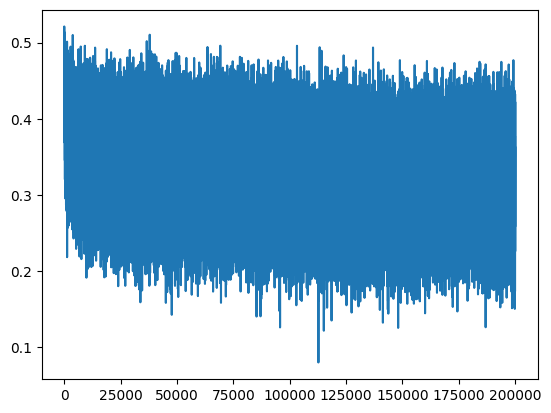

In [125]:
plt.plot(lossi)

In [128]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_runnig + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0657238960266113
val 2.109697103500366


In [129]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]  * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 
        # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_runnig + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:


            break
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
reigh.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiir.
kaleigh.
ham.
pora.
quinthonor.
wal.
addi.
waterra.
jarynix.
kaellinslee.


C:\Users\User\AppData\Local\Temp\ipykernel_14260\1275028977.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [130]:
# Let's train a deeper network

In [148]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar =  x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var =  (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters  = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [152]:
max_steps = 200000
batch_size = 32
lossi =  []

for i in  range(max_steps):
    ix  =  torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lr  = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0 /  200000: 3.5572
  10000 /  200000: 3.0425
  20000 /  200000: 3.2533
  30000 /  200000: 3.1201
  40000 /  200000: 3.1361
  50000 /  200000: 3.1322
  60000 /  200000: 2.6178
  70000 /  200000: 3.0428
  80000 /  200000: 3.0730
  90000 /  200000: 2.9218
 100000 /  200000: 3.2321
 110000 /  200000: 2.6662
 120000 /  200000: 2.9300
 130000 /  200000: 2.9772
 140000 /  200000: 2.5684
 150000 /  200000: 2.7733
 160000 /  200000: 2.8283
 170000 /  200000: 2.7429
 180000 /  200000: 2.6189
 190000 /  200000: 2.9287


layer 1 (      Tanh): mean +0.32, std 0.86, saturated: 70.38%
layer 3 (      Tanh): mean +0.31, std 0.93, saturated: 90.22%
layer 5 (      Tanh): mean +0.31, std 0.95, saturated: 100.00%
layer 7 (      Tanh): mean +0.31, std 0.95, saturated: 100.00%
layer 9 (      Tanh): mean +0.31, std 0.95, saturated: 100.00%


Text(0.5, 1.0, 'activation distribution')

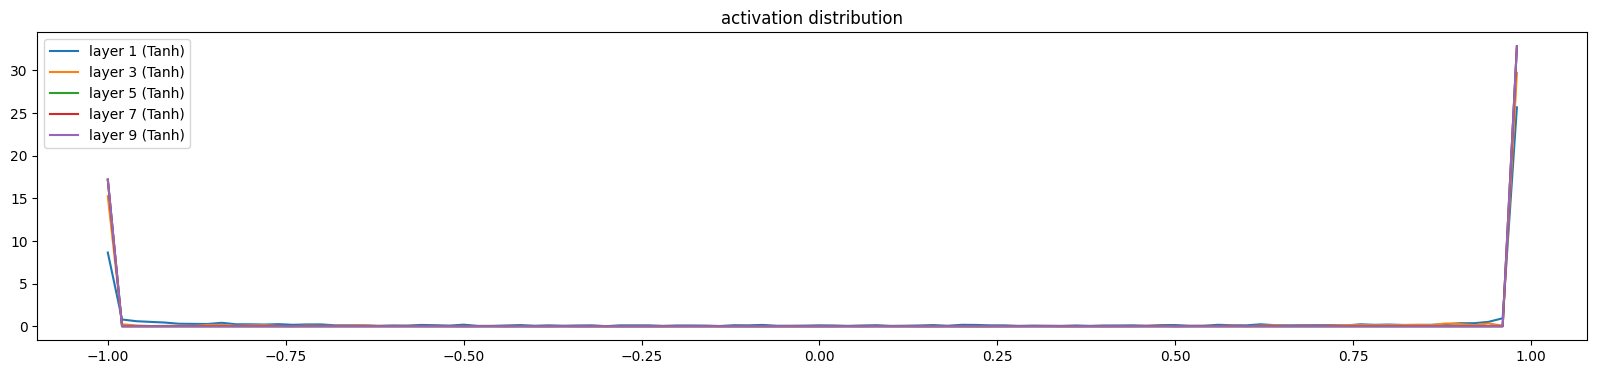

In [155]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

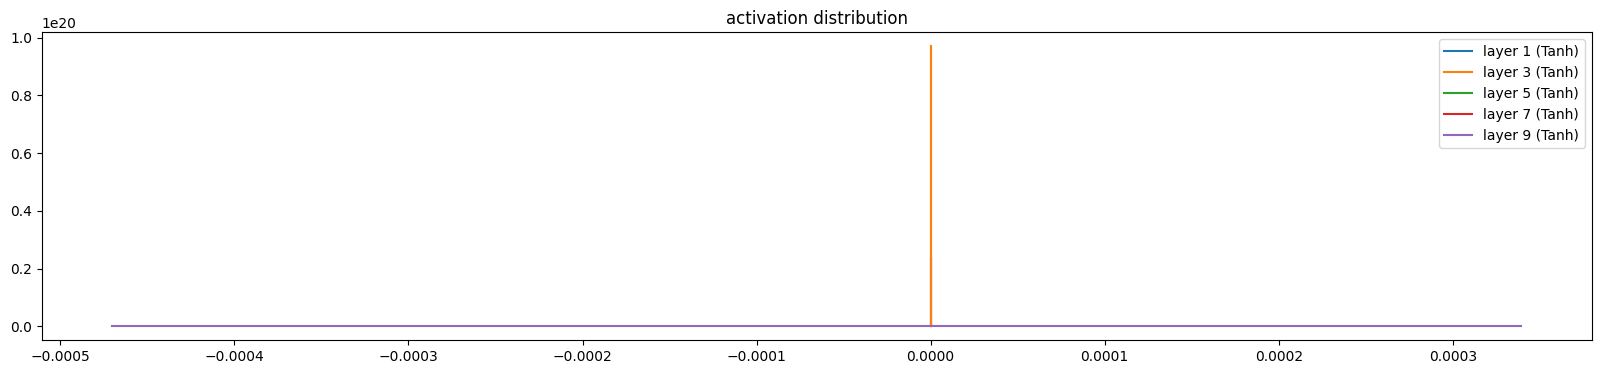

In [156]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')